<a href="https://colab.research.google.com/github/soham1492/soham1492/blob/main/Behavioural_Cloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/soham1492/Track_1

fatal: destination path 'Track_1' already exists and is not an empty directory.


In [ ]:
!ls Track_1

driving_log.csv  IMG


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
import cv2
import pandas as pd
import ntpath
import random
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.image as mpimg
%matplotlib inline

In [ ]:
datadir = "Track_1"
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names= columns)
pd.set_option('display.max_colwidth', -1)
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


,center,left,right,steering,throttle,reverse,speed
0,C:\Users\soham\Desktop\SDC\Udacity Simulator Data\IMG\center_2021_11_12_11_08_07_988.jpg,C:\Users\soham\Desktop\SDC\Udacity Simulator Data\IMG\left_2021_11_12_11_08_07_988.jpg,C:\Users\soham\Desktop\SDC\Udacity Simulator Data\IMG\right_2021_11_12_11_08_07_988.jpg,0.0,0.0,0.0,0.000081
1,C:\Users\soham\Desktop\SDC\Udacity Simulator Data\IMG\center_2021_11_12_11_08_08_090.jpg,C:\Users\soham\Desktop\SDC\Udacity Simulator Data\IMG\left_2021_11_12_11_08_08_090.jpg,C:\Users\soham\Desktop\SDC\Udacity Simulator Data\IMG\right_2021_11_12_11_08_08_090.jpg,0.0,0.0,0.0,0.000081
2,C:\Users\soham\Desktop\SDC\Udacity Simulator Data\IMG\center_2021_11_12_11_08_08_195.jpg,C:\Users\soham\Desktop\SDC\Udacity Simulator Data\IMG\left_2021_11_12_11_08_08_195.jpg,C:\Users\soham\Desktop\SDC\Udacity Simulator Data\IMG\right_2021_11_12_11_08_08_195.jpg,0.0,0.0,0.0,0.000080
3,C:\Users\soham\Desktop\SDC\Udacity Simulator Data\IMG\center_2021_11_12_11_08_08_298.jpg,C:\Users\soham\Desktop\SDC\Udacity Simulator Data\IMG\left_2021_11_12_11_08_08_298.jpg,C:\Users\soham\Desktop\SDC\Udacity Simulator Data\IMG\right_2021_11_12_11_08_08_298.jpg,0.0,0.0,0.0,0.000080
4,C:\Users\soham\Desktop\SDC\Udacity Simulator Data\IMG\center_2021_11_12_11_08_08_400.jpg,C:\Users\soham\Desktop\SDC\Udacity Simulator Data\IMG\left_2021_11_12_11_08_08_400.jpg,C:\Users\soham\Desktop\SDC\Udacity Simulator Data\IMG\right_2021_11_12_11_08_08_400.jpg,0.0,0.0,0.0,0.000081


In [ ]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

data['center'] =data['center'].apply(path_leaf)
data['left'] =data['left'].apply(path_leaf)
data['right'] =data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2021_11_12_11_08_07_988.jpg,left_2021_11_12_11_08_07_988.jpg,right_2021_11_12_11_08_07_988.jpg,0.0,0.0,0.0,0.000081
1,center_2021_11_12_11_08_08_090.jpg,left_2021_11_12_11_08_08_090.jpg,right_2021_11_12_11_08_08_090.jpg,0.0,0.0,0.0,0.000081
2,center_2021_11_12_11_08_08_195.jpg,left_2021_11_12_11_08_08_195.jpg,right_2021_11_12_11_08_08_195.jpg,0.0,0.0,0.0,0.000080
3,center_2021_11_12_11_08_08_298.jpg,left_2021_11_12_11_08_08_298.jpg,right_2021_11_12_11_08_08_298.jpg,0.0,0.0,0.0,0.000080
4,center_2021_11_12_11_08_08_400.jpg,left_2021_11_12_11_08_08_400.jpg,right_2021_11_12_11_08_08_400.jpg,0.0,0.0,0.0,0.000081


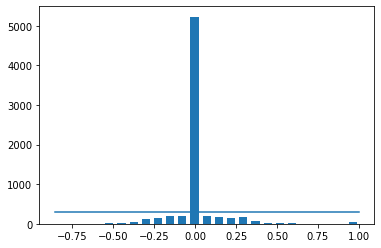

In [ ]:
num_bins = 25
samples_per_bin = 300
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:])* 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total_data 6815
removed: 4926
remaining data: 1889


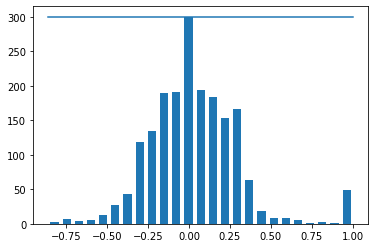

In [ ]:
print('total_data', len(data))
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    if data['steering'][i]>= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining data:', len(data))


hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))


In [ ]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)




In [ ]:
X_train, X_val, y_train, y_val = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_val)))

Training Samples: 1511
Valid Samples: 378


Text(0.5, 1.0, 'Validation Set')

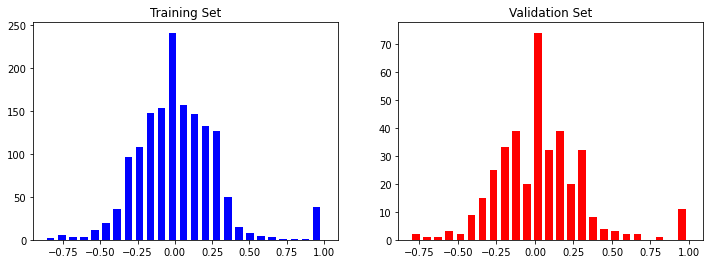

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(y_train,bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training Set')
axes[1].hist(y_val,bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation Set')


In [ ]:
def img_preprocess(img):
  img = mpimg.imread(img)
  img = img[60:135, :, :]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3,3), 0)
  img = cv2.resize(img, (200, 66))
  img = img/255
  return img



Text(0.5, 1.0, 'Preprocessed Image')

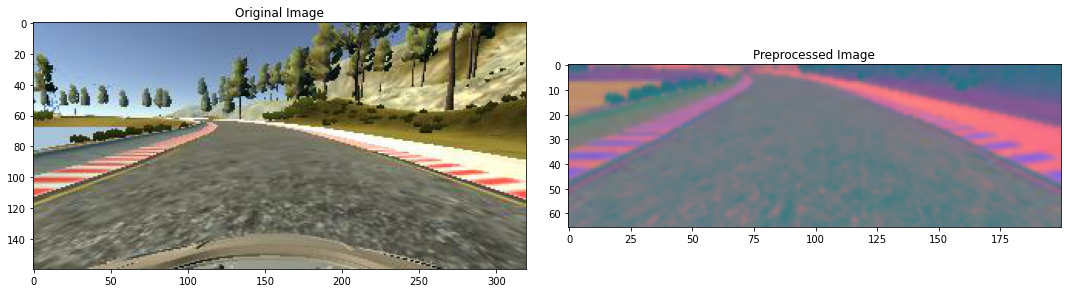

In [ ]:
image = image_paths[70]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

fig, axs = plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')


In [ ]:
X_train = np.array(list(map(img_preprocess, X_train)))
X_val = np.array(list(map(img_preprocess, X_val)))

(1511, 66, 200, 3)


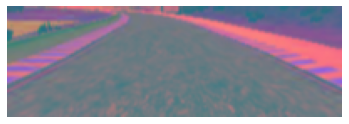

In [ ]:
plt.imshow(X_train[random.randint(0, len(X_train) -1)])
plt.axis('off')
print(X_train.shape)

In [ ]:
def nvidia_model():
 
  model = Sequential()
  model.add(Conv2D(24, kernel_size=(5,5), strides=(2,2), input_shape=(66,200,3),activation='relu'))
  model.add(Conv2D(36, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Conv2D(48, kernel_size=(5,5), strides=(2,2), activation='elu'))
  model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
  model.add(Conv2D(64, kernel_size=(3,3), activation='elu'))
  model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(100, activation='elu'))
  model.add(Dropout(0.5))

  model.add(Dense(50, activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(10, activation ='elu'))
  model.add(Dropout(0.5))

  model.add(Dense(1))
 
  optimizer= Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
 
  return model

In [ ]:
model = nvidia_model()
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 31, 98, 24)        1824      
                                                                 
 conv2d_31 (Conv2D)          (None, 14, 47, 36)        21636     
                                                                 
 conv2d_32 (Conv2D)          (None, 5, 22, 48)         43248     
                                                                 
 conv2d_33 (Conv2D)          (None, 3, 20, 64)         27712     
                                                                 
 conv2d_34 (Conv2D)          (None, 1, 18, 64)         36928     
                                                                 
 dropout_16 (Dropout)        (None, 1, 18, 64)         0         
                                                                 
 flatten_6 (Flatten)         (None, 1152)             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
h = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), batch_size=100, verbose=1, shuffle=1)

Epoch 1/30
16/16 [==============================] - 2s 64ms/step - loss: 0.5184 - val_loss: 0.0820
Epoch 2/30
16/16 [==============================] - 1s 43ms/step - loss: 0.1064 - val_loss: 0.0788
Epoch 3/30
16/16 [==============================] - 1s 41ms/step - loss: 0.0829 - val_loss: 0.0758
Epoch 4/30
16/16 [==============================] - 1s 40ms/step - loss: 0.0757 - val_loss: 0.0772
Epoch 5/30
16/16 [==============================] - 1s 42ms/step - loss: 0.0770 - val_loss: 0.0731
Epoch 6/30
16/16 [==============================] - 1s 42ms/step - loss: 0.0729 - val_loss: 0.0654
Epoch 7/30
16/16 [==============================] - 1s 42ms/step - loss: 0.0667 - val_loss: 0.0620
Epoch 8/30
16/16 [==============================] - 1s 42ms/step - loss: 0.0656 - val_loss: 0.0621
Epoch 9/30
16/16 [==============================] - 1s 42ms/step - loss: 0.0708 - val_loss: 0.0632
Epoch 10/30
16/16 [==============================] - 1s 41ms/step - loss: 0.0674 - val_loss: 0.0631
Epoch 11/

Text(0.5, 0, 'Epoch')

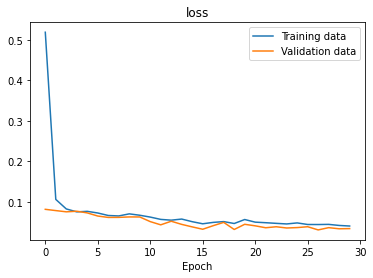

In [ ]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['Training data', 'Validation data'])
plt.title('loss')
plt.xlabel('Epoch')

In [ ]:
model.save('Model.h5')

In [ ]:
from google.colab import files
files.download('Model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>